In [225]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
import pandas as pd
from skimage.measure import EllipseModel

""
## set fig params
sns.set_context("paper")
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {
        'text.latex.preamble': r'\usepackage{amsmath} \boldmath',
        'text.usetex':True,
        'axes.labelsize':20.,
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'figure.figsize':[10., 8.],
        'font.family':'DejaVu Sans',
        'legend.fontsize':18}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

u.set_enabled_equivalencies(u.mass_energy())

In [226]:
gauss_to_GeV = 1.95e-20*u.GeV**2/(1.*u.Gauss)

In [227]:
## load OG data
al = pd.read_csv('../data/Al2O3_gayy_Reach_Baverage.csv', names=['m', 'gayy'], skiprows=1)
ca = pd.read_csv('../data/CaWO4_gayy_Reach_Baverage.csv', names=['m', 'gayy'], skiprows=1)
ga = pd.read_csv('../data/GaAs_gayy_Reach_Baverage.csv', names=['m', 'gayy'], skiprows=1)
si = pd.read_csv('../data/SiO2_gayy_Reach_Baverage.csv', names=['m', 'gayy'], skiprows=1)

In [228]:
al[~np.isnan(al.astype('float')['gayy'])]

,m,gayy
0,0.010000,5512107.041051274
1,0.010005,5453438.18558826
2,0.010009,5395373.830164924
3,0.010014,5337907.963689694
4,0.010018,5281034.632546861
...,...,...
7684,0.340058,5.892986966860601e+139
7685,0.340215,9.502155966838848e+139
7686,0.340372,1.5024227768685081e+140
7687,0.340528,2.375538991709712e+140


In [229]:
## load dielectric data
ga_die = pd.read_csv('dielectric_data_gaas.dat', names=['omega', 'Im(einv)']) ## Fig. 7 left from: https://arxiv.org/pdf/2104.12786.pdf

In [230]:
## load kappa data. Fig. 11 from https://arxiv.org/pdf/2104.12786.pdf
ga_kappa = pd.read_csv('gaas_kappa.dat', names=['mv', 'kappa'])
si_kappa = pd.read_csv('sio2_kappa.dat', names=['mv', 'kappa'])
al_kappa = pd.read_csv('al2o3_kappa.dat', names=['mv', 'kappa'])

In [231]:
def rate_dielectric(ma, diel_dat, rhoa=0.4*u.GeV, gayy=1.*u.GeV**(-1), Bext=((10*u.T).to(u.Gauss)*gauss_to_GeV).to(u.GeV**2), rhoT=(1.*u.kg).to(u.GeV)):
    ## fix rhoT, rhoa
    prefac = (rhoa/rhoT*1./ma**2).to(u.GeV**(-2))
    
    return (prefac*gayy**2*diel_dat*Bext**2).to('')

In [232]:
def gayy_limit(ma, diel_dat):
    rate = rate_dielectric(ma, diel_dat)
    ## 2005.10256 assumes 3 events / kg*yr
    return 3./rate

In [233]:
def gayy_limit_from_kappa(ma, kappa, Bext=((10*u.T).to(u.Gauss)*gauss_to_GeV).to(u.GeV**2)):
    return (kappa * ma/Bext).to(1./u.GeV)

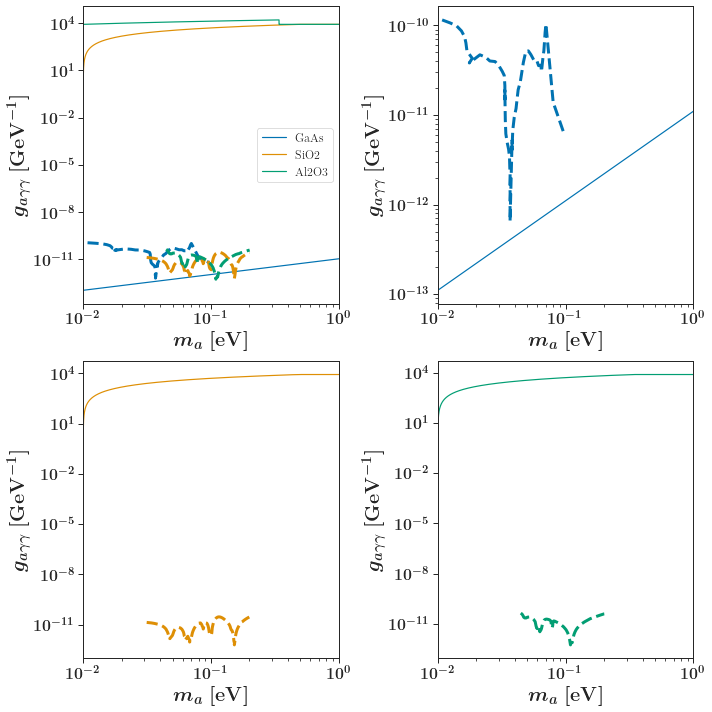

In [234]:
f, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].plot(ga['m'], ga['gayy'], c=cs[0], label='GaAs')
ax[0,0].plot(si['m'], si['gayy'], c=cs[1], label='SiO2')
ax[0,0].plot(al['m'], al['gayy'], c=cs[2], label='Al2O3')
ax[0,0].plot((ga_kappa['mv'].to_numpy()*u.eV).value,
           gayy_limit_from_kappa(ga_kappa['mv'].to_numpy()*u.eV, ga_kappa['kappa'].to_numpy()),
          ls='dashed', c=cs[0], lw=3)
ax[0,0].plot((si_kappa['mv'].to_numpy()*u.eV).value,
           gayy_limit_from_kappa(si_kappa['mv'].to_numpy()*u.eV, si_kappa['kappa'].to_numpy()),
          ls='dashed', c=cs[1], lw=3)
ax[0,0].plot((al_kappa['mv'].to_numpy()*u.eV).value,
           gayy_limit_from_kappa(al_kappa['mv'].to_numpy()*u.eV, al_kappa['kappa'].to_numpy()),
          ls='dashed', c=cs[2], lw=3)
ax[0,1].plot(ga['m'], ga['gayy'], c=cs[0], label='GaAs')
ax[1,0].plot(si['m'], si['gayy'], c=cs[1], label='SiO2')
ax[1,1].plot(al['m'], al['gayy'], c=cs[2], label='Al2O3')
ax[0,1].plot((ga_kappa['mv'].to_numpy()*u.eV).value,
           gayy_limit_from_kappa(ga_kappa['mv'].to_numpy()*u.eV, ga_kappa['kappa'].to_numpy()),
          ls='dashed', c=cs[0], lw=3)
ax[1,0].plot((si_kappa['mv'].to_numpy()*u.eV).value,
           gayy_limit_from_kappa(si_kappa['mv'].to_numpy()*u.eV, si_kappa['kappa'].to_numpy()),
          ls='dashed', c=cs[1], lw=3)
ax[1,1].plot((al_kappa['mv'].to_numpy()*u.eV).value,
           gayy_limit_from_kappa(al_kappa['mv'].to_numpy()*u.eV, al_kappa['kappa'].to_numpy()),
          ls='dashed', c=cs[2], lw=3)

ax[0,0].legend(fontsize=12)
[i.set_xscale('log') for i in ax.flat];
[i.set_yscale('log') for i in ax.flat];
# [i.set_ylim([1.e-13, 1.e-7]) for i in ax.flat];
[i.set_xlim([1.e-2, 1.]) for i in ax.flat];
[i.set_xlabel(r'$m_a~[\rm{eV}]$') for i in ax.flat];
[i.set_ylabel(r'$g_{a\gamma\gamma}~[\rm{GeV}^{-1}]$') for i in ax.flat];
f.tight_layout()

In [235]:
ga['gayy'].dropna()

0          1.103274e-13
1          1.103279e-13
2          1.103284e-13
3          1.103289e-13
4          1.103294e-13
               ...     
999998     1.103254e-11
999999     1.103259e-11
1000000    1.103264e-11
1000001    1.103269e-11
1000002    1.103274e-11
Name: gayy, Length: 1000003, dtype: float64

Text(0, 0.5, '$g_{a\\gamma\\gamma}~[\\rm{GeV}^{-1}]$')

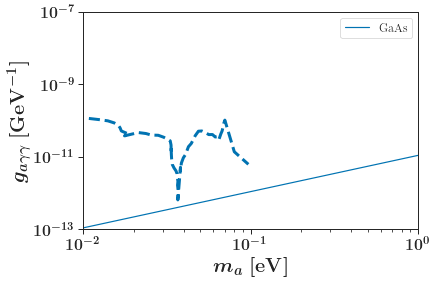

In [236]:
plt.figure()
plt.loglog(ga['m'], ga['gayy'], c=cs[0], label='GaAs')
# plt.loglog(si['m'], si['gayy'], c=cs[1], label='SiO2')
# plt.loglog(al['m'], al['gayy'], c=cs[2], label='Al2O3')
plt.loglog((ga_kappa['mv'].to_numpy()*u.eV).value,
           gayy_limit_from_kappa(ga_kappa['mv'].to_numpy()*u.eV, ga_kappa['kappa'].to_numpy()),
          ls='dashed', c=cs[0], lw=3)
# plt.loglog((si_kappa['mv'].to_numpy()*u.eV).value,
#            gayy_limit_from_kappa(si_kappa['mv'].to_numpy()*u.eV, si_kappa['kappa'].to_numpy()),
#           ls='dashed', c=cs[1], lw=3)
# plt.loglog((al_kappa['mv'].to_numpy()*u.eV).value,
#            gayy_limit_from_kappa(al_kappa['mv'].to_numpy()*u.eV, al_kappa['kappa'].to_numpy()),
#           ls='dashed', c=cs[2], lw=3)
plt.legend(fontsize=12)
plt.ylim([1.e-13, 1.e-7])
plt.xlim([1.e-2, 1.])
plt.xlabel(r'$m_a~[\rm{eV}]$')
plt.ylabel(r'$g_{a\gamma\gamma}~[\rm{GeV}^{-1}]$')

Text(0, 0.5, '$g_{a\\gamma\\gamma}~[\\rm{GeV}^{-1}]$')

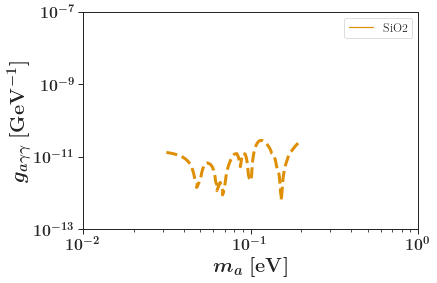

In [237]:
plt.figure()
# plt.loglog(ga['m'], ga['gayy'], c=cs[0], label='GaAs')
plt.loglog(si['m'], si['gayy'], c=cs[1], label='SiO2')
# plt.loglog(al['m'], al['gayy'], c=cs[2], label='Al2O3')
# plt.loglog((ga_kappa['mv'].to_numpy()*u.eV).value,
#            gayy_limit_from_kappa(ga_kappa['mv'].to_numpy()*u.eV, ga_kappa['kappa'].to_numpy()),
#           ls='dashed', c=cs[0], lw=3)
plt.loglog((si_kappa['mv'].to_numpy()*u.eV).value,
           gayy_limit_from_kappa(si_kappa['mv'].to_numpy()*u.eV, si_kappa['kappa'].to_numpy()),
          ls='dashed', c=cs[1], lw=3)
# plt.loglog((al_kappa['mv'].to_numpy()*u.eV).value,
#            gayy_limit_from_kappa(al_kappa['mv'].to_numpy()*u.eV, al_kappa['kappa'].to_numpy()),
#           ls='dashed', c=cs[2], lw=3)
plt.legend(fontsize=12)
plt.ylim([1.e-13, 1.e-7])
plt.xlim([1.e-2, 1.])
plt.xlabel(r'$m_a~[\rm{eV}]$')
plt.ylabel(r'$g_{a\gamma\gamma}~[\rm{GeV}^{-1}]$')

Text(0, 0.5, '$g_{a\\gamma\\gamma}~[\\rm{GeV}^{-1}]$')

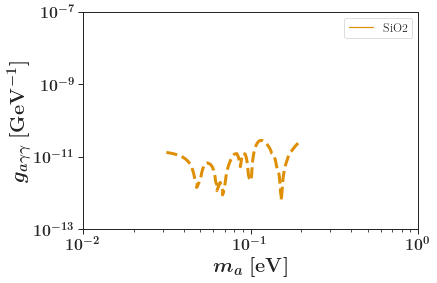

In [238]:
plt.figure()
# plt.loglog(ga['m'], ga['gayy'], c=cs[0], label='GaAs')
plt.loglog(si['m'], si['gayy'], c=cs[1], label='SiO2')
# plt.loglog(al['m'], al['gayy'], c=cs[2], label='Al2O3')
# plt.loglog((ga_kappa['mv'].to_numpy()*u.eV).value,
#            gayy_limit_from_kappa(ga_kappa['mv'].to_numpy()*u.eV, ga_kappa['kappa'].to_numpy()),
#           ls='dashed', c=cs[0], lw=3)
plt.loglog((si_kappa['mv'].to_numpy()*u.eV).value,
           gayy_limit_from_kappa(si_kappa['mv'].to_numpy()*u.eV, si_kappa['kappa'].to_numpy()),
          ls='dashed', c=cs[1], lw=3)
# plt.loglog((al_kappa['mv'].to_numpy()*u.eV).value,
#            gayy_limit_from_kappa(al_kappa['mv'].to_numpy()*u.eV, al_kappa['kappa'].to_numpy()),
#           ls='dashed', c=cs[2], lw=3)
plt.legend(fontsize=12)
plt.ylim([1.e-13, 1.e-7])
plt.xlim([1.e-2, 1.])
plt.xlabel(r'$m_a~[\rm{eV}]$')
plt.ylabel(r'$g_{a\gamma\gamma}~[\rm{GeV}^{-1}]$')

In [239]:
def L_func(omega, omega_0, width):

	return (
		4.0*omega*omega_0*width*( ( omega**2 - omega_0**2 )**2 + (omega*width)**2 )**(-1)
		)

In [240]:
def gaussian(omega, omega_0, width):
	# print(f'Omega ratio: {omega/omega_0}')
	# print(f'Width: {width}')
	# print(f'Exp arg: {-1.*(omega-omega_0)**2/width**2}')
	# return 2. * omega/omega_0 * (np.sqrt(np.pi) * width)**(-1) * np.exp(-1.*(omega - omega_0)**2 / width**2)
	return np.pi * np.sqrt(2) * (width)**(-1) * np.exp(-np.sqrt(2)*(omega - omega_0)**2 / width**2)
#     return -0.5 * (np.log10(omega)-np.log10(omega_0))**2/ np.log10(width)**2

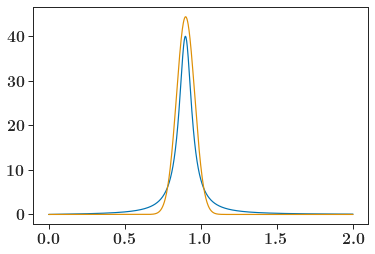

In [241]:
xs = np.linspace(0,2,1000)
plt.figure()
plt.plot(xs, L_func(xs, 0.9, 0.1))
plt.plot(xs, gaussian(xs, 0.9, 0.1))

In [242]:
width = np.ones((5))*0.001
omega_0 = np.array([3.48825457e-02, 3.48825371e-02, 3.48825281e-02, 2.75904849e-05, 2.28487871e-05])
omega = np.logspace(-2, 1,100)

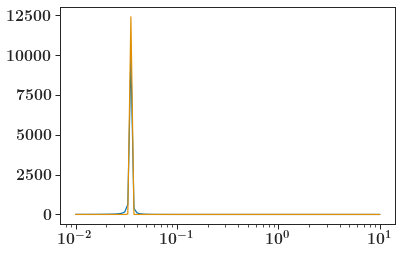

In [243]:
plt.figure()
plt.plot(omega, [np.sum(L_func(o, omega_0, width)) for o in omega])
plt.plot(omega, [np.sum(gaussian(o, omega_0, width)) for o in omega])
plt.xscale('log')
